# Naive Risk Budgeting Strategies between the PSP and GHP

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import edhec_risk_kit as erk

In [3]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a backtest of allocating between two sets of returns
    r1 and r2 are TxN DataFrames of returns where T is the time step index and 
    N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific params and
    produces an allocation to the first portfolio (the rest of the money is invested in the GHP)
    as a Tx1 DataFrame.
    Returns a TxN DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
    
    weights = allocator(r1, r2, **kwargs)
    
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that don't match r1")
        
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [4]:
def fixed_mix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are TxN DataFrames that represent the returns of the PSP and GHP such that:
      each column is a scenario
      each row is the price for a timestep
    Returns a TxN DataFrame of PSP weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [8]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)

price_10 = erk.bond_price(10, 100, 0.05, 12, rates)
price_30 = erk.bond_price(30, 100, 0.05, 12, rates)

rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)

rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixed_mix_allocator, w1=0.5)
mean_rets_bonds = rets_bonds.mean(axis="columns")
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
0,0.036654,0.004008,-0.040452,2.759086,-0.001091,-0.000616,1.61559,0.0


In [9]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [11]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixed_mix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis="columns")
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
0,0.058394,0.005248,0.028358,2.927792,-0.00227,-0.001592,5.266364,0.0


In [12]:
summaries = erk.summary_stats(rets_7030b)

In [13]:
summaries.head()

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
0,0.024606,0.114271,-0.541638,3.833892,0.055783,0.077218,-0.046087,-0.329171
1,0.059701,0.109647,0.106145,2.562060,0.045829,0.057824,0.263514,-0.210984
2,0.086335,0.108813,0.095633,2.636743,0.043415,0.053753,0.503777,-0.148377
3,0.015975,0.104093,0.004597,3.276871,0.047245,0.061661,-0.131254,-0.267018
4,0.040098,0.109887,-0.370248,2.874771,0.051500,0.065849,0.089305,-0.307493


In [14]:
summaries.mean()

annualized return          0.052802
annualized vol             0.108565
skewness                   0.003388
kurtosis                   2.965813
Cornish-Fisher VaR (5%)    0.046556
historic CVaR (5%)         0.059039
sharpe ratio               0.206782
max drawdown              -0.212140
dtype: float64

This two ways of summarizing will give you an idea but it's not the proper way of doing things. 

the proper way to do this is to look at the terminal value. At the end of the day how much cash do you have?

In [15]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30")
], axis=1)

,FI,Eq,70/30
mean,1.387758,1.929933,1.757730
std,0.147229,0.952551,0.588932
p_breach,NaN,0.062000,0.028000
e_short,NaN,0.170602,0.066518
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


### What this is saying

For every dollar that we invested in these different strategies across 500 scenarios tested:

* Fixed income strategy: 40/60 between long and short term bond. You'll end up with 1.38. Probability of ending below our floor is NaN.
* Equities: 1.98. Gave us a much better upside, but theres a 6% probability that we'll end up below 80 cents on the dollar and (e_short is how much I undershot by) on average if we miss we're gonna miss by 18cents.
* 70/30: 1.79. Less probability of falling short and shortfall is smaller.

We set our floor at 0.8, our minimum acceptable liability, a number which I absolutely don't want to be below. 

What can we do to make sure that we can actually hit that liability no matter what happens. **coming in last session**

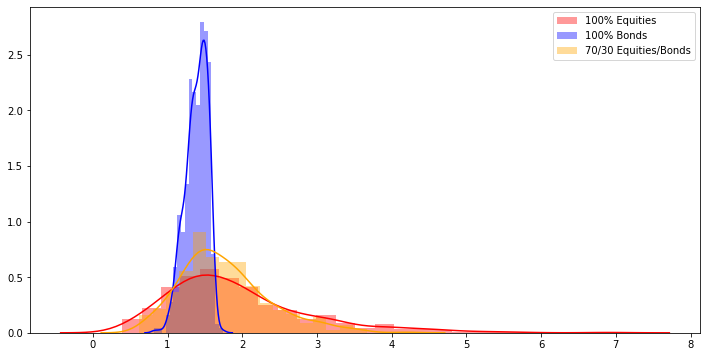

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities") # risky
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds") # conservative
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend()

## Glide Paths for Allocation

Let's define our weights, our risk budgeting technique, to not be a fixed mix of 70 and 30, let's start with something like 80% or 90% in stocks and then glide our way so that over those 10 years we end up at maybe 20%. 

In [18]:
def glide_path_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a target-date-fund style gradual move from r1 to r2
    """
    n_points = r.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis="columns")
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [20]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, 
                        allocator=erk.glide_path_allocator,
                        start_glide=0.80, end_glide=0.20)

pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20")
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.387758,1.929933,1.757730,1.645113
std,0.147229,0.952551,0.588932,0.420002
p_breach,NaN,0.062000,0.028000,0.002000
e_short,NaN,0.170602,0.066518,0.116589
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


Helps but doesn't solve the problem